In [ ]:
!pip install wandb

In [110]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import wandb, cv2
import numpy as np
from wandb.keras import WandbCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt

In [85]:
tf.__version__

'2.6.0'

In [86]:
wandb.init(project='Face_Recognition')

In [87]:
folder_address = '/content/drive/MyDrive/Datasets/7-7 dataset/'

batch_size = 8
width = height = 224

config = wandb.config
config.learning_rate = 0.001

In [88]:
data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    validation_split = 0.1,
    horizontal_flip = True
)

train_data = data_generator.flow_from_directory(folder_address,
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    subset ='training')

val_data = data_generator.flow_from_directory(folder_address,
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    subset ='validation')

Found 1228 images belonging to 14 classes.
Found 131 images belonging to 14 classes.


In [89]:
train_data.image_shape

(224, 224, 3)

In [99]:
class MyModel(tf.keras.Model):
  def __init__(self, number_of_classes):
    super().__init__()
    self.conv1 = Conv2D(32, (3, 3), activation='relu', input_shape = (width, height, 3))
    # self.conv2 = Conv2D(16, (3, 3), activation='relu')
    # self.conv3 = Conv2D(32, (3, 3), activation='relu')
    self.flatten = Flatten()
    self.fc1 = Dense(128, activation='relu')
    self.fc2 = Dense(64, activation='relu')
    self.fc3 = Dense(number_of_classes, activation='softmax')

  def call(self, x):

    x = self.conv1(x)
    # x = self.flatten(x)
    # x = self.conv2(x)
    x = self.flatten(x)
    # x = self.conv3(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    output = self.fc3(x)

    return output

model = MyModel(14)

In [100]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer =  tf.keras.optimizers.Adam()

In [101]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.CategoricalAccuracy(name='train_acc')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.CategoricalAccuracy(name='test_acc')

In [102]:
configs = {
              "learning_rate": 0.001,
              "epochs": 20,
              "batch_size": 8,
              "log_step": 200,
              "val_log_step": 50
           }

run = wandb.init(project='Face_Recognition', config=configs)
config = wandb.config

In [103]:
def train_step(images, y):
    with tf.GradientTape() as tape:
        y_pred = model(images, training = True)
        loss = tf.keras.losses.categorical_crossentropy(y, y_pred)

    #gradient calculate
    gradients = tape.gradient(loss, model.trainable_variables)

    #update
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_acc(y, y_pred)


In [104]:
def test_step(images, y):
  y_pred = model(images, training = False)
  loss = tf.keras.losses.categorical_crossentropy(y, y_pred)

  test_loss(loss)
  test_acc(y, y_pred)

In [105]:
def train():
    epochs = 20

    for epoch in range(epochs):

        train_loss.reset_state()
        train_acc.reset_state()
        test_loss.reset_state()
        test_acc.reset_state()

        count_for_train = 0
        count_for_test = 0

        i_train = len(train_data)
        i_test = len(val_data)

        for images, labels in tqdm(train_data):
            train_step(images, labels)
            count_for_train += 1
            if count_for_train > i_train:
                break

        for images, labels in tqdm(val_data):
            test_step(images, labels)
            count_for_test += 1
            if count_for_test > i_test:
                break

        print('epoch:', epoch + 1)
        print('loss:', train_loss.result())
        print('accuracy:', train_acc.result())
        print('val loss:', test_loss.result())
        print('val accuracy:', test_acc.result())

        wandb.log({'epochs': epoch,
            'train_loss': np.mean(train_loss.result()),
            'train_acc': float(train_acc.result()), 
            'test_loss': np.mean(test_loss.result()),
            'test_acc': float(test_acc.result())
            })

In [106]:
print(train_data)

In [107]:
train()

100%|██████████| 17/17 [01:38<00:00,  5.80s/it]


epoch: 1
loss: tf.Tensor(8.738399, shape=(), dtype=float32)
accuracy: tf.Tensor(0.2936893, shape=(), dtype=float32)
val loss: tf.Tensor(1.7132022, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.48920864, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


epoch: 2
loss: tf.Tensor(1.0110974, shape=(), dtype=float32)
accuracy: tf.Tensor(0.69983816, shape=(), dtype=float32)
val loss: tf.Tensor(1.0037329, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.7122302, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.32it/s]


epoch: 3
loss: tf.Tensor(0.4532809, shape=(), dtype=float32)
accuracy: tf.Tensor(0.88349515, shape=(), dtype=float32)
val loss: tf.Tensor(0.98865646, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.7410072, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.45it/s]


epoch: 4
loss: tf.Tensor(0.2091296, shape=(), dtype=float32)
accuracy: tf.Tensor(0.94012946, shape=(), dtype=float32)
val loss: tf.Tensor(0.7925668, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.7410072, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.33it/s]


epoch: 5
loss: tf.Tensor(0.13691251, shape=(), dtype=float32)
accuracy: tf.Tensor(0.96359223, shape=(), dtype=float32)
val loss: tf.Tensor(0.79420644, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.7553957, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.36it/s]


epoch: 6
loss: tf.Tensor(0.05572726, shape=(), dtype=float32)
accuracy: tf.Tensor(0.9854369, shape=(), dtype=float32)
val loss: tf.Tensor(0.8047163, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8057554, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


epoch: 7
loss: tf.Tensor(0.046221882, shape=(), dtype=float32)
accuracy: tf.Tensor(0.98867315, shape=(), dtype=float32)
val loss: tf.Tensor(0.64140016, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8201439, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.40it/s]


epoch: 8
loss: tf.Tensor(0.034319833, shape=(), dtype=float32)
accuracy: tf.Tensor(0.99271846, shape=(), dtype=float32)
val loss: tf.Tensor(0.64551735, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8201439, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.38it/s]


epoch: 9
loss: tf.Tensor(0.017362447, shape=(), dtype=float32)
accuracy: tf.Tensor(0.9951456, shape=(), dtype=float32)
val loss: tf.Tensor(0.6127457, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.82733816, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.38it/s]


epoch: 10
loss: tf.Tensor(0.0025163486, shape=(), dtype=float32)
accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
val loss: tf.Tensor(0.5607608, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8417266, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.44it/s]


epoch: 11
loss: tf.Tensor(0.044926707, shape=(), dtype=float32)
accuracy: tf.Tensor(0.99029124, shape=(), dtype=float32)
val loss: tf.Tensor(0.95436084, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.76258993, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.42it/s]


epoch: 12
loss: tf.Tensor(0.053900294, shape=(), dtype=float32)
accuracy: tf.Tensor(0.9854369, shape=(), dtype=float32)
val loss: tf.Tensor(0.9460044, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.76258993, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


epoch: 13
loss: tf.Tensor(0.0034779557, shape=(), dtype=float32)
accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
val loss: tf.Tensor(0.67774236, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8345324, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.44it/s]


epoch: 14
loss: tf.Tensor(0.001747836, shape=(), dtype=float32)
accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
val loss: tf.Tensor(0.6990114, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8345324, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.41it/s]


epoch: 15
loss: tf.Tensor(0.00044387078, shape=(), dtype=float32)
accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
val loss: tf.Tensor(0.7298403, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8201439, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.42it/s]


epoch: 16
loss: tf.Tensor(0.0014929959, shape=(), dtype=float32)
accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
val loss: tf.Tensor(0.64447314, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8417266, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


epoch: 17
loss: tf.Tensor(0.00033744465, shape=(), dtype=float32)
accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
val loss: tf.Tensor(0.6658842, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8208955, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.47it/s]


epoch: 18
loss: tf.Tensor(0.00023036402, shape=(), dtype=float32)
accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
val loss: tf.Tensor(0.70983386, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.8417266, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.42it/s]


epoch: 19
loss: tf.Tensor(0.15462181, shape=(), dtype=float32)
accuracy: tf.Tensor(0.9644013, shape=(), dtype=float32)
val loss: tf.Tensor(2.4882085, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.4676259, shape=(), dtype=float32)


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]

epoch: 20
loss: tf.Tensor(0.20409514, shape=(), dtype=float32)
accuracy: tf.Tensor(0.93608415, shape=(), dtype=float32)
val loss: tf.Tensor(1.1565443, shape=(), dtype=float32)
val accuracy: tf.Tensor(0.7122302, shape=(), dtype=float32)


In [108]:
model.save('/content/drive/MyDrive/models/face_recognition_model.h5')

In [128]:
persons = ['علی خامنه ای',
           'انجلینا جولی',
           'باراک اوباما',
           'بهنام بانی',
           'دونالد ترامپ',
           'اما واتسون',
           'سوسانو',
           'رهبر کره شمالی',
           'لیلا حاتمی',
           'مسی',
           'میشل اوباما',
           'مرگان فریمن',
           'ملکه الیزابت',
           'اسکارلت جوهانسون']

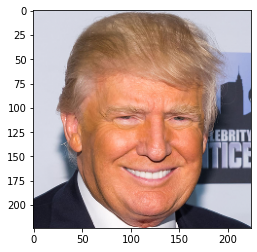

In [133]:
image = cv2.imread('trump.jpeg')
image = cv2.resize(image, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0
plt.imshow(image)
image = tf.expand_dims(image, axis=0)

In [134]:
y_pred = model(image, training = False)
res = np.argmax(y_pred)

In [135]:
persons[res]

'دونالد ترامپ'